In [1]:
import torch
from torch import nn

import numpy as np
import pennylane as qml
from torchvision import datasets, transforms
from tqdm import trange

In [97]:
N_SAMPLES = 1000
N_QUBITS = 4
N_LAYERS = 1
BATCH_SIZE = 50
N_EPOCHS = 4
LEARNING_RATE = 0.01
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [98]:
## Fetch and process MNIST data

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((4, 4), antialias=None),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)
mnist = datasets.MNIST("./data", train=True, download=True, transform=transform)

# Get only 6s and 3s
idx = np.where((mnist.targets == 6) | (mnist.targets == 3))[0]
mnist.data = mnist.data[idx]
mnist.targets = mnist.targets[idx]

# Limit to N_SAMPLES
mnist.data = mnist.data[:N_SAMPLES]
mnist.targets = mnist.targets[:N_SAMPLES]

# Change labels to 0 and 1
mnist.targets[mnist.targets == 6] = 0
mnist.targets[mnist.targets == 3] = 1

In [99]:
## Define circuit

dev = qml.device('default.qubit', wires=N_QUBITS)

def get_circuit(differentiator):

    @qml.qnode(dev, diff_method=differentiator, interface='torch')
    def circuit(inputs, weights):

        # Encoding
        for i in range(N_QUBITS):
            qml.RY(inputs[i], wires=i)

        # Classifier
        for l in range(N_LAYERS):
            layer_params = weights[N_QUBITS * l : N_QUBITS * (l + 1)]
            for i in range(N_QUBITS):
                qml.CRZ(layer_params[i], wires=[i, (i + 1) % N_QUBITS])
            for i in range(N_QUBITS):
                qml.Hadamard(wires=i)

        return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]
    
    return circuit

In [100]:
## Define torch model


class Model(nn.Module):
    def __init__(self, differentiator, n_wires, n_layers) -> None:
        super().__init__()
        weight_shapes = {"weights": (n_layers * n_wires,)}

        circuit = get_circuit(differentiator)
        self.quanv = qml.qnn.TorchLayer(circuit, weight_shapes)

        self.flatten = nn.Flatten(start_dim=1)
        self.linear = nn.Linear(N_QUBITS * 2 * 2, 2)
        self.softmax = nn.Softmax(dim=1)
        self.final = nn.Sequential(self.flatten, self.linear, self.softmax)

    def forward(self, x):

        bsz = x.shape[0]
        img_size = x.shape[1]
        # x = x.view(bsz, img_size, img_size)

        all_circuit_outs = []

        for j in range(0, img_size, 2):
            for k in range(0, img_size, 2):
                image_portion = torch.cat((
                    x[:, j, k],
                    x[:, j, k + 1],
                    x[:, j + 1, k],
                    x[:, j + 1, k + 1],
                ))

                data = torch.transpose(image_portion.view(4, bsz), 0, 1)

                circuit_outs = self.quanv(data)
                all_circuit_outs.append(circuit_outs)

        x = torch.cat(all_circuit_outs, dim=1).float()
        x = self.final(x)
        return x

In [102]:
def get_losses(differentiator):

    trainloader = torch.utils.data.DataLoader(
        mnist, batch_size=BATCH_SIZE, shuffle=True
    )

    model = Model(differentiator, N_QUBITS, N_LAYERS)
    model.to(DEVICE)
    
    opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss = nn.CrossEntropyLoss()


    # Initial evaluation
    initial_loss = 0.0
    initial_acc = 0.0

    for batch_idx, (data, target) in enumerate(trainloader):
        data = data.squeeze().to(DEVICE)
        target = target.to(DEVICE)
        output = model(data)
        l = loss(output, target)
        initial_loss += l.item()
        initial_acc += output.argmax(dim=1).eq(target).sum().item()

    initial_loss /= len(trainloader)
    initial_acc /= len(trainloader)

    losses = [initial_loss]
    avg_accs = [initial_acc]

    # Circuit evaluations
    init_circuit_evals = dev.num_executions
    circuit_evals = [0]

    # Training loop
    for epoch in trange(N_EPOCHS, desc="Epochs"):
        running_acc = 0
        for batch_idx, (data, target) in enumerate(trainloader):
            data = data.squeeze().to(DEVICE)
            target = target.to(DEVICE)
            output = model(data)

            l = loss(output, target)
            losses.append(l.item())

            opt.zero_grad()
            l.backward()
            opt.step()
            
            accuracy = output.argmax(dim=1).eq(target).sum().item()
            running_acc += accuracy * len(target)
            circuit_evals.append(dev.num_executions - init_circuit_evals)

        avg_accs.append(running_acc / len(trainloader.dataset))

        # print(f"Epoch {epoch+1}/{N_EPOCHS}, Loss: {losses[-1]}, Accuracy: {avg_accs[-1]}")

    return losses, avg_accs, circuit_evals


In [103]:
losses_spsb, accs_spsb, evals_spsb = get_losses('spsa')
losses_ps, accs_ps, evals_ps = get_losses('parameter-shift')

losses_spsb, accs_spsb, evals_spsb = np.array(losses_spsb), np.array(accs_spsb), np.array(evals_spsb)
losses_ps, accs_ps, evals_ps = np.array(losses_ps), np.array(accs_ps), np.array(evals_ps)

Epochs: 100%|██████████| 4/4 [03:42<00:00, 55.71s/it]


In [104]:
def rolling_avg(data, window_size):
    convolution = np.convolve(data, np.ones((window_size,)) / window_size, mode="valid")
    return np.append(data[: window_size - 1], convolution)

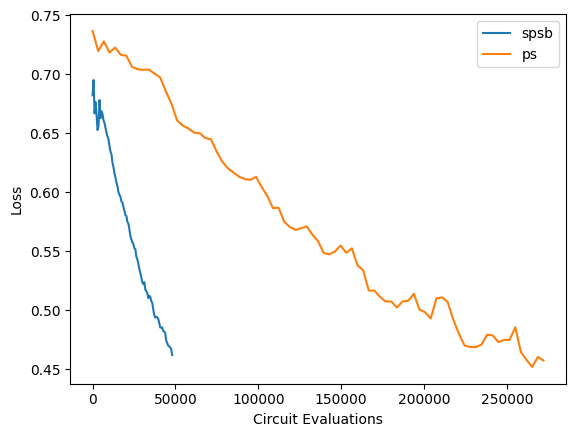

In [110]:
from matplotlib import pyplot as plt

# Take rolling average of losses
differentiators = ["spsb", "ps"]
average_windows = {"spsb": 10, "ps": 3}
data = {
    "spsb": {"losses": losses_spsb, "accs": accs_spsb, "evals": evals_spsb},
    "ps": {"losses": losses_ps, "accs": accs_ps, "evals": evals_ps},
}


for d in differentiators:
    losses_plot = rolling_avg(data[d]["losses"], average_windows[d])

    plt.plot(data[d]["evals"], losses_plot, label=d)


plt.xlabel("Circuit Evaluations")
plt.ylabel("Loss")
plt.legend();
